# Assembling the imperfect waterbomb elements

Prototyping notebook -- that was used to formulate the processing of the 
assembly algorithm and misfit analysis step by step. The methods were then 
included in the class WBAssembler 

In [1]:
import k3d
import sympy as sp
sp.init_printing()
import numpy as np
import matplotlib.pylab as plt
from bmcs_shell.folding.assembly.wb_scanned_cell import WBScannedCell, cache_solve

# Modules 3

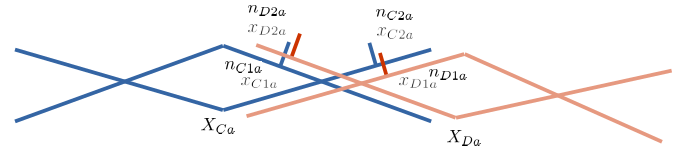

There are two cells positioned in a 2D Euclidian space indexed $C$ and $D$.
In the following, an index $a$ denotes the spatial coordinate index in 2D with the values 0 and 1. Both cells $C$ and $D$ have two reference points provided in the local coordinate system of the cells as $x_{C0a}$, $x_{C1a} and $x_{D0a}$, $x_{D1a}$, respectively. Each reference point is associated with a vector defined in the local coordinates of the cells, i.e., $n_{C0a}$, $n_{C1a}$ and $n_{D0a}$, $n_{D1a}$. Each cell is embedded in the global 2D coordinate system via the position of the origin of the local coordinate system of the cell $X_{Ca}$ and $X_{Da}$ and the rotations of the local coordinate systems $\alpha_C$ and $\alpha_D$.

The position of the reference points in local coordinate systems of the respective shells and the associated vectors are known as input parameters. Also the global position $X_{Ca}$ and the rotation angle $\alpha_C$ are input parameters. The global position $X_{Da}$ and the rotation $\alpha_D$ are unknown. The task is to identify these three unknown based on the following three criteria:

 - First criterion: The angle between vectors $n_{C1a}$ and $n_{D2a}$ transformed to the global coordinated system using the respective angles $\alpha_C$ and $\alpha_D$ must be zero. This condition might be formulated as 
 $ \| T_{Cab}(\alpha_C) n_{C2a}$ $T_{Dcd}(\alpha_D) n_{D1c} \epsilon_{ebd} \| = 0, where $T_{Cab}$ is the rotation matrix depending on the angle $\alpha_C$, $T_{Dcd}$ is the rotation matrix depending on the angle $\alpha_D$, and $\epsilon_{ebd}$ represents the cross-product operator, sometimes referred to as Levi-Civita. But a simpler criterion using dot product and quantified angles is also possible.  

 - Second criterion: Introducing the vector $v_{D1a} = (X_{Ca} + T_{Cab}(\alpha_C) x_{C2a} ) - (X_{Da} + T_{Dab}(\alpha_D) x_{D1a})$ in the global coordinate system, the second criterion says that its projected length on the associated vector must be equal to a specified distance $d$, i.e. $\| v_{D1b} T_{Dab}(\alpha) n_{D1b} \| = d$. 

 - Third criterion: The third criterion is similar to the second criterion, but it takes into account the cell $C$. Given the vector $v_{C1a} = (X_{Da} + T_{Dab}(\alpha_D) x_{D2a} ) - (X_{Ca} + T_{Cab}(\alpha_C) x_{C1a})$, we require that the projected length of the associated vector is equal to the specified parameter $d$, i.e. $\| v_{C1b} T_{Cab}(\alpha_C) n_{Ca} \| = d$.

The task is to resolve these criteria to deliver the closed-form solution for $X_{D0}, $X_{D1}$, and $\alpha_{D}$.
  


The three necessary conditions are stated as 
 - angle between $n_{C1a}$ and $n_{D2a}$ must be zero,
 - the size of the vector $X_{D2a} - X_{C1a}$ projected to $n_{C2a}$ must be equal to $d$
 - the size of the vector $X_{C2a} - X_{D1a}$ projected to $n_{C2a}$ must be equal to $d$
 

This means
 -  $ \| T_{Cab}(\alpha_C) n_{C2a}$ $T_{Dcd}(\alpha_D) n_{D1c} \epsilon_{ebd} \| = 0$
 - $v_{D1a} = (X_{Ca} + T_{Cab}(\alpha_C) x_{C2a} ) - (X_{Da} + T_{Dab}(\alpha_D) x_{D1a})$, and $\| v_{D1b} T_{Dab} n_{Da} \| = d$
 - $v_{C1a} = (X_{Da} + T_{Dab}(\alpha_D) x_{D2a} ) - (X_{Ca} + T_{Cab}(\alpha_C) x_{C1a})$, and $\| v_{C1b} T_{Cab} n_{Ca} \| = d$

   

A simpler expression is
Define the line vectors based on the normals as
$$
v_{Cfa} = [n_{Cf1}, -n_{Cf0}]
$$
$$
 T_{Ca} + s_C v_{C2a}
$$

## Derive the translation and rotation of a neighbor cell 

Introduce the variables

In [2]:
from sympy import symbols, Matrix, cos, sin, solve, Eq

# Define symbols
alpha_C, d_alpha_D = symbols('alpha_C d_alpha_D')
alpha_D = alpha_C + d_alpha_D

X_C = Matrix(symbols('X_C1, X_C2'))
X_D = Matrix(symbols('X_D1, X_D2'))
x_Cb = Matrix(symbols('x_Cb1, x_Cb2'))
x_Ct = Matrix(symbols('x_Ct1, x_Ct2'))
x_Db = Matrix(symbols('x_Db1, x_Db2'))
x_Dt = Matrix(symbols('x_Dt1, x_Dt2'))
n_Cb = Matrix(symbols('n_Cb1, n_Cb2'))
n_Ct = Matrix(symbols('n_Ct1, n_Ct2'))
n_Db = Matrix(symbols('n_Db1, n_Db2'))
n_Dt = Matrix(symbols('n_Dt1, n_Dt2'))

sp_vars = (alpha_C, X_C, x_Cb, x_Ct, x_Db, x_Dt, n_Cb, n_Ct, n_Db, n_Dt)

X_C1, X_C2 = X_C
X_D1, X_D2 = X_D

Symbols needed to determine the position in $x$ direction

In [3]:
X_C0 = symbols('X_C0')
X_D0 = symbols('X_D0')
X3_C = Matrix([X_C0, X_C1, X_C2])
X3_D = Matrix([X_D0, X_D1, X_D2])

In [4]:
# Rotation matrices
T_C = Matrix([[cos(alpha_C), -sin(alpha_C)], [sin(alpha_C), cos(alpha_C)]]).T
T_D = Matrix([[cos(alpha_D), -sin(alpha_D)], [sin(alpha_D), cos(alpha_D)]]).T


### Criterion 1:

Rotation between the neighbor cells
Calculate the angle between the normal vectors on the planes that interlock. This means the opposite planes

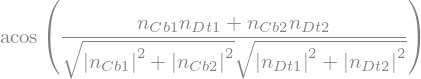

In [5]:
n_Cb_unit = n_Cb / n_Cb.norm()
n_Dt_unit = n_Dt / n_Dt.norm()

# Calculate dot product of n_Cb_global and n_Db_global
dot_product = n_Cb_unit.dot(n_Dt_unit)

# Check if dot product is equal to product of magnitudes
d_alpha_D_solved = sp.simplify(sp.acos(dot_product))
d_alpha_D_solved

### Criterion 2: 

The point X_D1 must be on the line running through X_C2 orthogonal to n_Ct

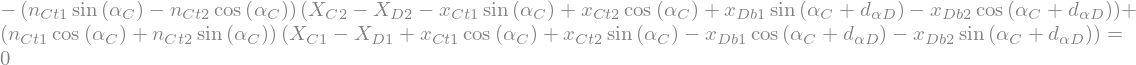

In [6]:
X_Ct = X_C + T_C * x_Ct
X_Db = X_D + T_D * x_Db
V_C2 = X_Ct - X_Db 
N_C2 = T_C * n_Ct
misfit_Ct = sp.simplify(V_C2.dot(N_C2))
criterion2 = sp.Eq( misfit_Ct, 0)
criterion2

### Criterion 3: 

The point X_Dt must be on the line given by the point X_Cb and 
a line perpendicular to N_Cb

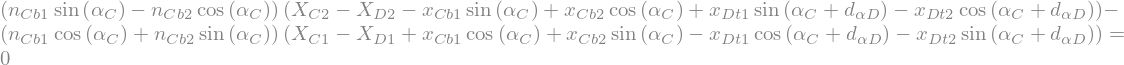

In [7]:
X_Cb = X_C + T_C * x_Cb
X_Dt = X_D + T_D * x_Dt
V_C1 = X_Dt - X_Cb
N_C1 = T_C * n_Cb
misfit_Cb = sp.simplify(V_C1.dot(N_C1))
criterion3 = sp.Eq( misfit_Cb, 0)
criterion3


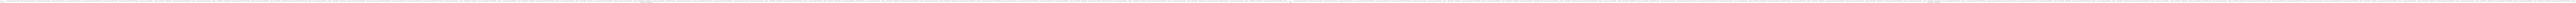

In [8]:
# Solve the system of equations
X_D_solved = cache_solve((criterion2, criterion3), [X_D1, X_D2], "X_D_solved") # , recalculate=True, simplify=True)
X_D_solved

In [9]:
# get_d_alpha_D = sp.lambdify(sp_vars, d_alpha_D_solved)
get_d_alpha_D = sp.lambdify((alpha_C, X_C, n_Cb, n_Dt), d_alpha_D_solved)
get_X_D1 = sp.lambdify(sp_vars + (d_alpha_D,), X_D_solved[X_D1])
get_X_D2 = sp.lambdify(sp_vars + (d_alpha_D,), X_D_solved[X_D2])
get_misfit_Ct = sp.lambdify(sp_vars + (d_alpha_D, X_D), misfit_Ct)
get_misfit_Cb = sp.lambdify(sp_vars + (d_alpha_D, X_D), misfit_Cb)


## Facets points from 3D scan

In [10]:
colors = [0xff0000, 0x00ff00, 0x0000ff, 0xffff00, 0xff00ff, 0x00ffff,
          0xff0099, 0xff9900, 0x99ff00, 0x00ff99, 0x9900ff, 0x0099ff,
          0xff9999, 0x99ff99, 0x9999ff, 0xffff99, 0xff99ff, 0x99ffff]

### Define the corner map

Define an index array with the shape (2,2,2) where first two dimensions denote corners  and the last dimension stands for bottom and top facet  

In [11]:
corner_map = np.array([[[17, 10],[15, 3], ], [[16, 10],[14, 3]]], dtype=np.int_)
diag_corner_map = np.array([[(0, 0), (0, 1)], [(1, 0), (1, 1)]])

def get_corner_f(diag_dir, y_dir):
    diag_index = 0 if diag_dir == -1 else 1
    y_index = 0 if y_dir == -1 else 1
    return corner_map[tuple(diag_corner_map[diag_index][y_index])]

In [12]:
x_dir_ = np.array([[1, -1],[-1, 1]])
def get_x_dir( diag_dir, y_dir):
    return diag_dir * y_dir
get_x_dir(-1, -1)

In [13]:
def plug_D_into_C(wb_plugged, wb_fixed, diag_dir, y_dir, d_X_0=565):
    """
    Plug wb_D into wb_C along the selected diagonal.
    """
    side_fixed, side_plugged = np.array([1, -1]) * y_dir
    x_Cfa = wb_fixed.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_fixed.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_plugged.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_plugged.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    alpha_C_ = wb_fixed.alpha
    X_C_ = wb_fixed.X_a[1:]

    d_alpha_D_n_ = y_dir * get_d_alpha_D(alpha_C_, X_C_, n_Cfa[0], n_Dfa[1])
    X_D1_ = get_X_D1(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_n_)
    X_D2_ = get_X_D2(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_n_)

    X_D0_ = wb_fixed.X_a[0] + d_X_0 * get_x_dir(diag_dir, y_dir)
    wb_plugged.alpha = alpha_C_ + d_alpha_D_n_
    wb_plugged.X_a = [X_D0_, X_D1_, X_D2_]

In [14]:
def get_misfit(wb_D, wb_C, diag_dir, y_dir=1):
    """
    Plug wb_D into wb_C along the diagonal diag.
    """
    side_fixed, side_plugged = np.array([1, -1]) * y_dir
    x_Cfa = wb_C.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_C.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_D.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_D.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    alpha_C_ = wb_C.alpha
    d_alpha_D_ = wb_D.alpha - alpha_C_
    X_C_ = wb_C.X_a[1:]
    X_D_ = wb_D.X_a[1:]

    misfit_Cb = get_misfit_Cb(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], 
                          n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_, X_D_)
    misfit_Ct = get_misfit_Ct(alpha_C_, X_C_, x_Cfa[0], x_Cfa[1], x_Dfa[0], x_Dfa[1], n_Cfa[0], 
                          n_Cfa[1], n_Dfa[0], n_Dfa[1], d_alpha_D_, X_D_)

    return misfit_Cb, misfit_Ct


In [15]:
def plot_plugged_neighbors_yz(wb_fixed, wb_plugged, diag_dir, y_dir, ax):

    side_fixed, side_plugged = np.array([1, -1]) * y_dir

    x_Cfa = wb_fixed.O_centroids_Fa[get_corner_f(diag_dir,side_fixed),1:]
    n_Cfa = wb_fixed.O_normals_Fa[get_corner_f(diag_dir,side_fixed),1:]
    x_Dfa = wb_plugged.O_centroids_Fa[get_corner_f(diag_dir,side_plugged),1:]
    n_Dfa = wb_plugged.O_normals_Fa[get_corner_f(diag_dir,side_plugged),1:]

    scale = 50
    x2_Cfa = x_Cfa + n_Cfa * scale
    x2_Dfa = x_Dfa + n_Dfa * scale

    nC_alf = np.einsum('lfa->alf', np.array([x_Cfa, x2_Cfa]))
    nD_alf = np.einsum('lfa->alf', np.array([x_Dfa, x2_Dfa]))

    ax.plot(*x_Cfa.T, 'o', color='blue')
    ax.plot(*x_Dfa.T, 'o', color='green')

    ax.plot(*nC_alf[:,:,0], color='orange')
    ax.plot(*nD_alf[:,:,1], color='orange')

    O_crease_lines_X_aLi = np.einsum('Lia->aiL', wb_fixed.O_crease_lines_X_Lia)
    ax.plot(*O_crease_lines_X_aLi[1:,...], color='blue')
    O_crease_lines_X_aLi = np.einsum('Lia->aiL', wb_plugged.O_crease_lines_X_Lia)
    ax.plot(*O_crease_lines_X_aLi[1:,...], color='green')

    ax.set_aspect('equal')


In [16]:
cell_enum = np.arange(1,13)

plug_pi = np.array([
    [0, 8, 1, 1],
    [0, 2, -1, 1],
    [2, 1, 1, -1],
    [2, 3, 1, 1],
    [3, 9, 1, 1],
    [3, 5, -1, 1],
    [5, 4, 1, -1],
    [4, 10, 1, -1],
    [5, 6, 1, 1],
    [5, 7, -1, 1],
    [7, 11, 1, -1]
], dtype=np.int_)

misfit_pi = np.array([
    [8, 3, -1, 1],
    [1, 10, -1, 1],
    [2, 4, -1, 1],
    [9, 6, -1, 1],
    [4, 11, -1, 1]
])

def get_slit_seq(slit_Si):
    cell_pair_pC = cell_enum[slit_Si[:,:2]] - 1
    from_slit_diag_p = slit_Si[:, 2]
    from_slit_dir_p = slit_Si[:, 3]
    return cell_pair_pC, from_slit_diag_p, from_slit_dir_p


In [17]:
def plug_modules(wbs, plug_pi):
    for wb_link, diag, dir in zip(*get_slit_seq(plug_pi)):
        wb_fixed, wb_plugged = wbs[wb_link]
        plug_D_into_C(wb_plugged, wb_fixed, diag, dir)

def reset_modules(wbs):
    for wb in wbs:
        wb.alpha = 0
        wb.X_a = [0,0,0]
        wb.O_flip = 1

def plot_modules_3D(wbs, plot, module_numbers=True, facet_numbers=False):
    for i, wb in enumerate(wbs):
        color = colors[i % len(colors)]
        wb.plot_points(plot, wb.G_centroids_Fa[[14,15,16,17]], point_size=8, plot_numbers=facet_numbers)
        wb.plot_G_facets(plot, color=color, module_numbers=module_numbers)

def plot_modules_yz(wbs, ax):
    for i, wb in enumerate(wbs):
        G_crease_lines_X_aLi = np.einsum('Lia->aiL', wb.G_crease_lines_X_Lia)
        ax.plot(*G_crease_lines_X_aLi[1:,...], color='black')
    ax.set_aspect('equal')

def plot_modules_xz(wbs, ax):
    for i, wb in enumerate(wbs):
        G_crease_lines_X_aLi = np.einsum('Lia->aiL', wb.G_crease_lines_X_Lia)
        ax.plot(*G_crease_lines_X_aLi[[0,2],...], color='black')
    ax.set_aspect('equal')


### Read the scanned files for individual cells

Demonstrator series

In [18]:
modules = {'WB305': ('WB305_facets_points.obj', [[1, 0], [np.pi/2, np.pi/2]]),
           'WB306': ('WB306_facets_points.obj', [[1, 0], [np.pi/2, -np.pi/2]]),
           'WB307': ('WB307_facets_points.obj', [[1], [np.pi/2]]),
           'WB308': ('WB308_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
           'WB309': ('WB309_facets_points.obj', [[0, 2], [np.pi/2, -np.pi/2]]),
           'WB310': ('WB310_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
           'WB311': ('WB311_facets_points.obj', [[1], [np.pi/2]]),
           'WB312': ('WB312_facets_points.obj', [[1], [-np.pi/2]]),
           'WB313': ('WB307_facets_points.obj', [[1], [np.pi/2]]),
           'WB314': ('WB310_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
           'WB315': ('WB311_facets_points.obj', [[1], [np.pi/2]]),
           'WB316': ('WB311_facets_points.obj', [[1], [np.pi/2]]),
           }


modules_list = [(k, *v, c) for (k, v), c in zip(sorted(modules.items()), colors) ]

In [19]:
# modules = {key: ('WB305_facets_points.obj', [[1, 0, 2], [np.pi/2, np.pi/2, 0]]) for key in 
#            ['WB305', 
#             'WB306', 'WB307', 'WB308', 'WB309', 'WB310', 'WB311', 'WB312', 'WB313', 'WB314', 'WB315', 'WB316'
#             ]}
# modules_list = [(k, *v, c) for (k, v), c in zip(sorted(modules.items()), colors) ]

In [20]:
def read_modules(modules):
    return np.array([WBScannedCell(file_path=file, label=key,
                                         rotate_system=rotate_system) 
        for key, file, rotate_system, _ in modules_list ], dtype=np.object_)

wbs = read_modules(modules)
wbs.shape

In [21]:
wb = wbs[4]
plot = k3d.plot(name='Vectors')
wb.plot_groups_of_points(plot, wb.wb_scan_X_Fia)
wb.plot_points(plot, wb.centroids_Fa, point_size=20, 
                      color=0x000000, plot_numbers=True)
# wb.plot_points(plot, wb.isc_points_Li, point_size=20, 
#                      color=0x0000ff, plot_numbers=False)
# wb.plot_intersection_lines(plot)
plot.display()

/Users/gui/Documents/bmcs_folder/bmcs_virtual/lib/python3.12/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

In [22]:

plot = k3d.plot(name='Vectors')
#wb.plot_points(plot, wb.O_centroids_Fa, plot_numbers=True)
plot_modules_3D(wbs[4:5], plot, facet_numbers=False, module_numbers=False)
plot.display()

Output()

In [23]:
plot = k3d.plot(name='Vectors')
wbs = read_modules(modules)
plug_modules(wbs, plug_pi[:])
plot_modules_3D(wbs, plot)
# Display the plot and the legend side by side
plot.display()

Output()

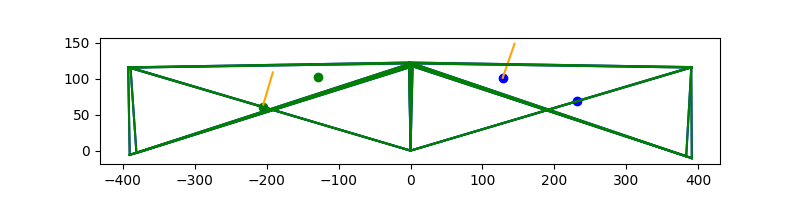

In [24]:
%matplotlib widget


wb_C = wbs[8]
wb_D = wbs[8]
diag_dir = 1
y_dir = 1
fig, ax = plt.subplots(1,1, figsize=(8,2))
plot_plugged_neighbors_yz(wb_C, wb_D, diag_dir, y_dir, ax)



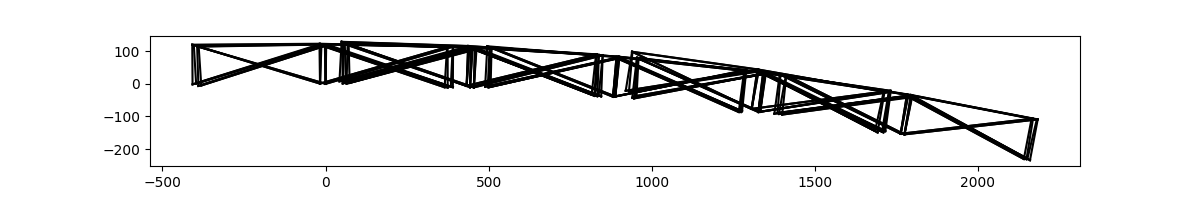

In [25]:
fig, ax = plt.subplots(1,1,figsize=(12,2))
plot_modules_yz(wbs, ax)

## Quantification of misfit

In [26]:
def get_module_misfits(wbs, slit_pi):
    misfits_ = []
    for wb_link, diag, dir in zip(*get_slit_seq(slit_pi)):
        wb_fixed, wb_plugged = wbs[wb_link]
        m1 = get_misfit(wb_plugged, wb_fixed, diag, dir)
        misfits_.append(m1)

    misfits = np.array(misfits_)
    return misfits

In [27]:
get_module_misfits(wbs, plug_pi)

array([[ 2.13162821e-14,  0.00000000e+00],
       [-2.13162821e-14,  0.00000000e+00],
       [-1.42108547e-14, -1.42108547e-14],
       [ 8.52651283e-14,  8.88178420e-14],
       [ 3.48165941e-13,  1.74082970e-13],
       [-4.97379915e-14, -2.48689958e-14],
       [-4.61852778e-14, -4.26325641e-14],
       [-4.97379915e-14, -1.27897692e-13],
       [ 2.62900812e-13,  8.52651283e-14],
       [-2.91322522e-13, -8.88178420e-14],
       [-5.50670620e-14, -9.23705556e-14]])

In [28]:
get_module_misfits(wbs, misfit_pi)

array([[ -1.76609903,  -1.57082161],
       [  8.57700392,  -2.41104935],
       [ -0.46051718,  -3.22367126],
       [  9.54925845,   2.26492229],
       [ 10.14773943, -16.74594895]])

## All possible cell arrangements

Combine 8 entities of type A and four entities of type B in all possible ordered sequences of 12 entities. While the type A entities go to the first 8 slots, the type B entities go to the last 4 slots. The entities are identified by integers starting from 1 ... 8 for type A and 9 ... 12 for type B. Further, the type A entities are assumed to have either positive or negative sign. However, their combinations are not assumed arbitrary. The signs in the slots [0, 1, 3, 4, 6, 7] are assumed always opposite to the slots [2, 5]. 

In [29]:
import itertools

# Create arrays of entities
entities_A = np.arange(1, 9)  # Entities of type A
entities_B = np.arange(9, 13)  # Entities of type B

# Generate all permutations for both types
perms_A = np.array(list(itertools.permutations(entities_A)))
perms_B = np.array(list(itertools.permutations(entities_B)))

# Create sign arrays
signs_1 = np.array([1, 1, -1, 1, 1, -1, 1, 1])
signs_2 = -signs_1
alter_signs = np.array([signs_1, signs_2])

perms_A_signed = perms_A[:, np.newaxis, :8] * alter_signs[np.newaxis, :, :]
perms_A = perms_A_signed.reshape(-1, 8)

# Combine permutations of A and B in all possible sequences
all_perms = np.array([np.concatenate((pa, pb)) for pa in perms_A for pb in perms_B])


In [30]:
all_perms.shape

## Run over several combinations and evaluate the misfit

In [31]:
def assembly_flip(wbs, flip_map):
    for wb, O_flip in zip(wbs, flip_map):
        wb.O_flip = O_flip

wbs = read_modules(modules)
combination_choice = np.random.choice(all_perms.shape[0], 5000, replace=False)
misfit_tC_ = []
for wb_perm in all_perms[combination_choice]:
    O_flip_map = np.sign(wb_perm)
    wb_C = np.abs(wb_perm) - 1
    wbs_t = wbs[wb_C]
    assembly_flip(wbs_t, O_flip_map)
    plug_modules(wbs_t, plug_pi)
    misfit_C = get_module_misfits(wbs_t, misfit_pi)
    misfit_tC_.append(misfit_C)
    reset_modules(wbs_t)
misfit_tC = np.array(misfit_tC_)

Choose the best assembly and plot it

In [32]:
best_t = np.argmin(np.max(np.fabs(misfit_tC), axis=(1,2)))
misfit_tC[best_t]

array([[-1.66136802,  2.40176806],
       [ 0.29049932,  1.89755305],
       [ 0.56819394, -0.92416952],
       [-2.02755772, -1.78050157],
       [ 2.00128679,  1.5128176 ]])

In [33]:
reset_modules(wbs)
O_flip_map = np.sign(all_perms[combination_choice[best_t]])
wbs_t = wbs[np.abs(all_perms[combination_choice[best_t]]) - 1]
assembly_flip(wbs_t, O_flip_map)

plot = k3d.plot(name='Vectors')
plug_modules(wbs_t, plug_pi)
plot_modules_3D(wbs_t, plot, module_numbers=False, facet_numbers=False)
plot.display()

/Users/gui/Documents/bmcs_folder/bmcs_virtual/lib/python3.12/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

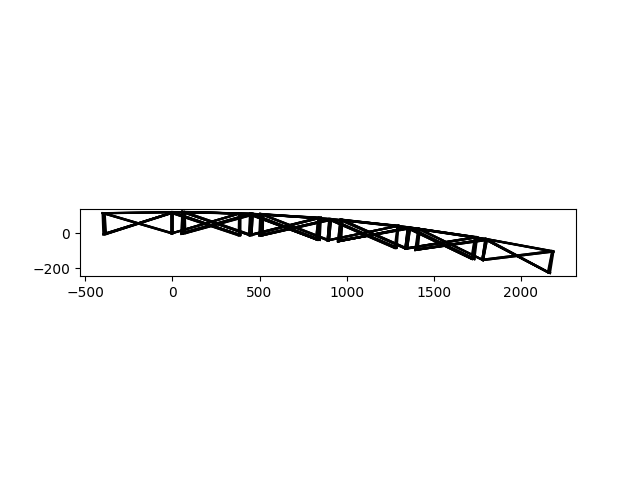

In [34]:
fig, ax = plt.subplots()
plot_modules_yz(wbs_t, ax)

## Extract the plugin support heights

In [35]:
wb_row_map = [[0, 1], [2, 8, 10], [3, 4], [5, 9, 11], [6, 7]]
def get_support_geometry(wbs_t, rows = wb_row_map):
    YZ_rows_, alpha_rows_ = [], []
    for row in rows:
        YZ_row = []
        alpha_row = []
        cells = wbs_t[row]
        for cell in cells:
            YZ_row.append(cell.X_a[1:])
            alpha_row.append(cell.alpha)
        YZ_rows_.append( np.average(np.array(YZ_row, dtype=np.float_), axis=0 ) )
        alpha_rows_.append( np.average(np.array(alpha_row, dtype=np.float_), axis=0 ) )
    return np.array(YZ_rows_, dtype=np.float_), np.array(alpha_rows_, dtype=np.float_)                

In [36]:
wb_X_Ca, wb_alpha_C = get_support_geometry(wbs_t)
wb_X_Ca

array([[-2.63701805e+00, -4.54272526e-01],
       [ 4.46605817e+02, -1.08389953e+01],
       [ 8.94881528e+02, -4.06651440e+01],
       [ 1.34163767e+03, -8.80634909e+01],
       [ 1.78161069e+03, -1.53497205e+02]])

Plot a vertical column of a width W and height H which denotes the distance from the floor at the level zero to a saddle point in the located at the height H in the middle of the column. There are two lines starting from the saddle towards the vertical boundaries of the column symmetrically at an angle $\gamma < \pi/2$. The intersections of these two lines with the vertical boundaries of the columns are higher than the saddle point. The column is filled with color `c`. The upper boundary of the column has a V-shape. An additional feature of the function is the possibility to tilt the V-shape by an angle $\alpha < \pi / 4$.    
 

In [37]:
from matplotlib.patches import Arc

def plot_support_vshape(ax, X, D, H, W, G, alpha, gamma, c, dist_dimline):
    # Calculate coordinates of the V-shape
    x_middle = X
    W2 = W / 2
    G2 = G / 2
    x_left = X - W2
    x_mid_left = X - G2
    x_right = X + W2
    x_mid_right = X + G2
    y_middle = H + D
    y_top_left = y_middle + np.tan(np.pi/2-gamma/2+alpha) * W2
    y_top_right = y_middle + np.tan(np.pi/2-gamma/2-alpha) * W2
    y_mid_left = y_middle + np.tan(np.pi/2-gamma/2+alpha) * G2
    y_mid_right = y_middle + np.tan(np.pi/2-gamma/2-alpha) * G2

    x = [x_left, x_mid_left, x_mid_left, x_left, x_left]
    y = [D, D, y_mid_left, y_top_left, D]
    ax.fill(x, y, c)
    ax.plot(x, y, color='black')

    x = [x_mid_right, x_right, x_right, x_mid_right, x_mid_right]
    y = [D, D, y_top_right, y_mid_right, D]
    ax.fill(x, y, c)
    ax.plot(x, y, color='black')

    # Create dimension lines
    ax.annotate("", xy=(x_left-dist_dimline, D), xytext=(x_left-dist_dimline, y_top_left), arrowprops=dict(arrowstyle='<->'))
    ax.text(x_left-dist_dimline, (y_top_left+D)/2, f"{y_top_left-D:.0f}", ha='right', va='center', rotation=90)

    ax.annotate("", xy=(x_right+dist_dimline, D), xytext=(x_right+dist_dimline, y_top_right), arrowprops=dict(arrowstyle='<->'))
    ax.text(x_right+dist_dimline, (y_top_right+D)/2, f"{y_top_right-D:.0f}", ha='left', va='center', rotation=90)

    ax.annotate("", xy=(x_middle, D), xytext=(x_middle, y_middle), arrowprops=dict(arrowstyle='<->'))
    ax.text(x_middle+dist_dimline/2, (y_middle+D)/2, f"{y_middle-D:.0f}", ha='center', va='center', rotation=90)

    ax.annotate("", xy=(x_middle, 0), xytext=(x_middle, D), arrowprops=dict(arrowstyle='<->'))
    ax.text(x_middle-dist_dimline, D/2, f"{D:.0f}", ha='center', va='center', rotation=90)

    ax.annotate("", xy=(x_left, D+dist_dimline), xytext=(x_right, D+dist_dimline), 
                arrowprops=dict(arrowstyle='<->'))
    ax.text(x_left, D+dist_dimline, f"{W:.0f}", ha='left', va='bottom', rotation=0)

    # Plot horizontal line
    ax.plot([x_middle-W/4, x_middle+W/4], [y_middle, y_middle], color='black')
    
    # Plot angles
    angle_left = np.degrees(np.pi/2-gamma/2+alpha)
    angle_right = np.degrees(np.pi/2-gamma/2-alpha)
    ax.add_patch(Arc((x_middle, y_middle), W/4, W/4, theta1=0, theta2=angle_left, 
                     edgecolor='black', linestyle='dashed'))
    ax.add_patch(Arc((x_middle, y_middle), W/4, W/4, theta1=180-angle_right, theta2=180,  
                     edgecolor='black', linestyle='dashed'))
    
    ax.text(x_middle+W/8, y_middle+30, f"{angle_right:.1f}$^\circ$", va='bottom', ha='left')
    ax.text(x_middle-W/8, y_middle+30, f"{angle_left:.1f}$^\circ$", va='bottom', ha='right')

    ax.set_aspect('equal')

    # switch off the axes
    ax.axis('off')

<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:57: SyntaxWarning: invalid escape sequence '\c'
<>:56: SyntaxWarning: invalid escape sequence '\c'
<>:57: SyntaxWarning: invalid escape sequence '\c'
/var/folders/x5/_7rzy47d3212sjtcr_thts7r0000gn/T/ipykernel_41948/2258063952.py:56: SyntaxWarning: invalid escape sequence '\c'
  ax.text(x_middle+W/8, y_middle+30, f"{angle_right:.1f}$^\circ$", va='bottom', ha='left')
/var/folders/x5/_7rzy47d3212sjtcr_thts7r0000gn/T/ipykernel_41948/2258063952.py:57: SyntaxWarning: invalid escape sequence '\c'
  ax.text(x_middle-W/8, y_middle+30, f"{angle_left:.1f}$^\circ$", va='bottom', ha='right')


### Get the average angle of the middle opposite facets [3, 10] 

In [38]:
def get_gamma_support(wbs_t):
    """Get the average dihedral angle between the supported middle facets    
    """
    gammas_ = []
    for wb in wbs_t:
        n1, n2 = wb.normals_Fa[[3,10]]
        gamma_ = np.pi - np.arccos(np.einsum('i,i->', n1, n2))
        gammas_.append(gamma_)
    gamma = np.average(np.array(gammas_))
    return gamma

In [39]:
def get_bounding_box(wbs_t):
    """Get the deepest node of the supplied cells
    """
    X_FNa_ = []
    for wb in wbs_t:
        X_Na = wb.G_crease_nodes_X_Na
        X_FNa_.append(X_Na)
    X_min = np.min(np.array(X_FNa_), axis=(0,1))
    X_max = np.max(np.array(X_FNa_), axis=(0,1))
    return X_min, X_max

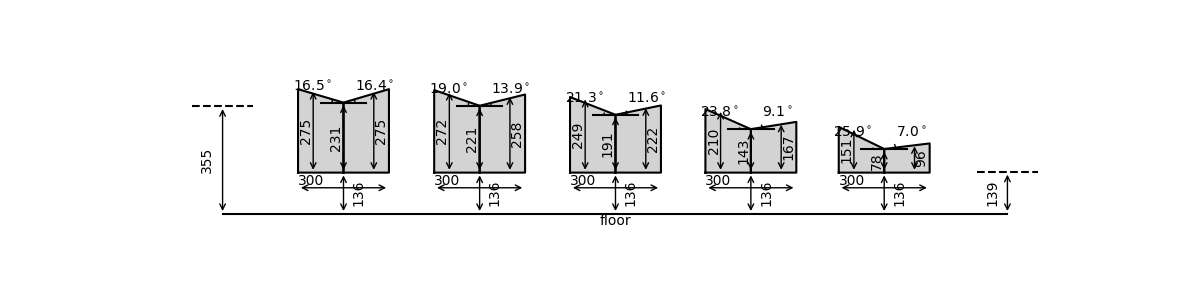

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12, 3))
fig.canvas.header_visible = False

D = 136

wb_X_Ca, wb_alpha_C = get_support_geometry(wbs_t)

min_y = np.min(wb_X_Ca[:,1])
base_height = 78
y_shift = base_height - min_y

y_values = [wb.X_a[2] for wb in wbs_t]

for X_Ca, alpha_C in zip(wb_X_Ca, wb_alpha_C):
    plot_support_vshape(ax, X=X_Ca[0], D=D, H=X_Ca[1]+y_shift, W=300, G=0, alpha=alpha_C, 
                gamma=get_gamma_support(wbs_t), c='lightgray', dist_dimline=-50)


for wb, y_value in zip(wbs_t, y_values):
    X_a = np.copy(wb.X_a)
    X_a[2] += D + y_shift
    wb.X_a = X_a

show_modules_yz = False
if show_modules_yz:
    plot_modules_yz(wbs_t, ax)

X_min, X_max = get_bounding_box(wbs_t[[6,7]])
y_arg = X_min[2]
x_max = X_max[1]
ax.annotate("", xy=(x_max, 0), xytext=(x_max, y_arg), arrowprops=dict(arrowstyle='<->'))
ax.text(x_max-50, (y_arg)/2, f"{y_arg:.0f}", ha='center', va='center', rotation=90)
ax.plot([x_max-100, x_max+100], [y_arg, y_arg], linestyle='dashed', color='black')

X_min, X_max = get_bounding_box(wbs_t[[0,1]])
y_arg = X_min[2]
x_min = X_min[1]
ax.annotate("", xy=(x_min, 0), xytext=(x_min, y_arg), arrowprops=dict(arrowstyle='<->'))
ax.text(x_min-50, (y_arg)/2, f"{y_arg:.0f}", ha='center', va='center', rotation=90)
ax.plot([x_min-100, x_min+100], [y_arg, y_arg], linestyle='dashed', color='black')

# Plot floor and its annotation
ax.plot([x_min, x_max], [0, 0], color='black')
ax.text((x_min+x_max)/2, 0, "floor", ha='center', va='top')

for wb, y_value in zip(wbs_t, y_values):
    X_a = np.copy(wb.X_a)
    X_a[2] = y_value
    wb.X_a = X_a

fig.savefig(fname='trolleys_longitudinal.pdf')    

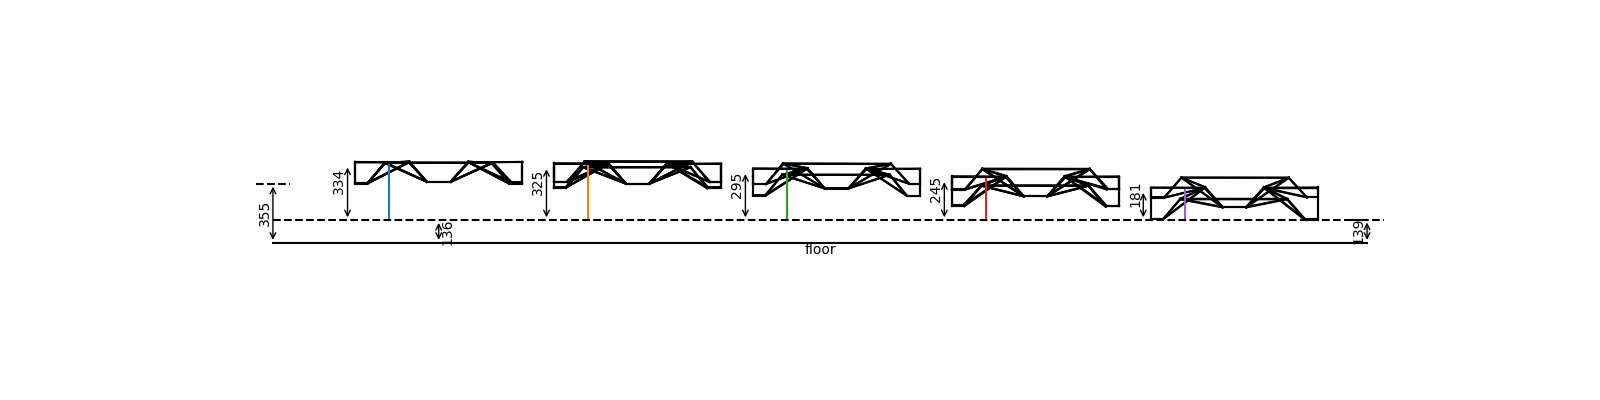

In [41]:
%matplotlib widget
fig, ax = plt.subplots(1,1, figsize=(16, 4))
fig.canvas.header_visible = False

delta_x = 1200
z_gap = 15

wb_X_Ca, wb_alpha_C = get_support_geometry(wbs_t)

min_y = np.min(wb_X_Ca[:,1])
base_height = 78
y_shift = base_height - min_y

x_values = [wb.X_a[0] for wb in wbs_t]
y_values = [wb.X_a[2] for wb in wbs_t]

for wb, y_value in zip(wbs_t, y_values):
    X_a = np.copy(wb.X_a)
    X_a[2] += D + y_shift
    wb.X_a = X_a

wb_row_map = [[0, 1], [2, 8, 10], [3, 4], [5, 9, 11], [6, 7]]
for i, row in enumerate(wb_row_map):
    x_shift = i * delta_x
    cells = wbs_t[row]

    for cell in cells:
        X_a = np.copy(cell.X_a)
        X_a[0] = x_shift
        cell.X_a = X_a
        X_Lia = cell.G_crease_lines_X_Lia[[17,18]]
        z_mountain = np.average(X_Lia[...,2]) - z_gap
    plot_modules_xz(cells, ax)
    ax.plot([x_shift-300, x_shift-300],[D,z_mountain])
    ax.annotate("", xy=(x_shift-550, D), xytext=(x_shift-550, z_mountain), arrowprops=dict(arrowstyle='<->'))
    ax.text(x_shift-550-50, D+z_mountain / 2, f"{z_mountain-D:.0f}", ha='center', va='center', rotation=90)

for wb, x_value in zip(wbs_t, x_values):
    X_a = np.copy(wb.X_a)
    X_a[0] = x_value
    wb.X_a = X_a

ax.annotate("", xy=(0, 0), xytext=(0, D), arrowprops=dict(arrowstyle='<->'))
ax.text(50, D/2, f"{D:.0f}", ha='center', va='center', rotation=90)

X_min, X_max = get_bounding_box(wbs_t[[6,7]])
y_arg = X_min[2]
x_max = (delta_x * 5 - 400)
ax.annotate("", xy=(x_max, 0), xytext=(x_max, y_arg), arrowprops=dict(arrowstyle='<->'))
ax.text(x_max-50, (y_arg)/2, f"{y_arg:.0f}", ha='center', va='center', rotation=90)
ax.plot([x_max-100, x_max+100], [y_arg, y_arg], linestyle='dashed', color='black')

X_min, X_max = get_bounding_box(wbs_t[[0,1]])
y_arg = X_min[2]
x_min = -1000
ax.annotate("", xy=(x_min, 0), xytext=(x_min, y_arg), arrowprops=dict(arrowstyle='<->'))
ax.text(x_min-50, (y_arg)/2, f"{y_arg:.0f}", ha='center', va='center', rotation=90)
ax.plot([x_min-100, x_min+100], [y_arg, y_arg], linestyle='dashed', color='black')

# Plot floor and its annotation
ax.plot([x_min, x_max], [D, D], linestyle='dashed', color='black')

# Plot floor and its annotation
ax.plot([x_min, x_max], [0, 0], color='black')
ax.text((x_min+x_max)/2, 0, "floor", ha='center', va='top')

ax.set_aspect('equal')
ax.axis('off');

fig.savefig(fname='trolleys_transverse.pdf')    